In [1]:
import pandas as pd 
import numpy as np

df = pd.read_csv('sample/testcases.csv')
df.head()

,_pathTag,Test Case Description,Priority,Can Automate,Is Automated,Validation points,Test Step Description
0,NaN,Sign up by email is already in uses,Medium,True,True,NaN,<li>Go to the register page. (https://app.grid...
1,NaN,Sign up by email is not in the correct format,Medium,False,False,NaN,<li>Go to the register page. (https://app.grid...
2,NaN,Sign up by company's name is already in use,Medium,False,False,NaN,<p>Go to the register page. (https://app.gridl...
3,NaN,Sign up by company's name is not yet used,Low,True,False,NaN,<li>Go to the register page. (https://app.grid...
4,NaN,Sign up by a password less than 4 characters,Low,True,False,NaN,<li>Go to the register page. (https://app.grid...


In [2]:
drop_list = ['Priority', 'Can Automate', 'Is Automated', 'Validation points', 'Test Step Description']
df = df.drop(columns=drop_list)
df = df.dropna()
df['pathTag_id'] = df['_pathTag'].factorize()[0]
pathTag_id_df = df[['_pathTag', 'pathTag_id']].drop_duplicates().sort_values('pathTag_id')
pathTag_to_id = dict(pathTag_id_df.values)
id_to_pathTag = dict(pathTag_id_df[['pathTag_id', '_pathTag']].values)
df.head()

,_pathTag,Test Case Description,pathTag_id
93,Permission,Verify 'Owner' can create a project,0
94,Permission,Verify 'Owner' can rename a project,0
95,Permission,Verify 'Owner' can delete a project,0
96,Project,"View information (Name , Description, Author, ...",1
97,Project,Edit description of workspace in about,1


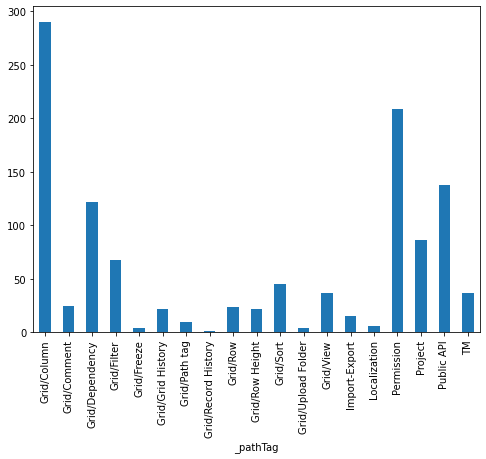

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('_pathTag')['Test Case Description'].count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df['Test Case Description']).toarray()
labels = df['pathTag_id']
features.shape

(1165, 329)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for feedbackType, pathTag_id in sorted(pathTag_to_id.items()):
  features_chi2 = chi2(features, labels == pathTag_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(feedbackType))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Grid/Column':
  . Most correlated unigrams:
. type
. copy
  . Most correlated bigrams:
. column data
. copy column
# 'Grid/Comment':
  . Most correlated unigrams:
. cell
. comment
  . Most correlated bigrams:
. delete comment
. comment cell
# 'Grid/Dependency':
  . Most correlated unigrams:
. new
. dependency
  . Most correlated bigrams:
. dependency column
. new dependency
# 'Grid/Filter':
  . Most correlated unigrams:
. filter
. condition
  . Most correlated bigrams:
. add filter
. filter column
# 'Grid/Freeze':
  . Most correlated unigrams:
. single
. multiple
  . Most correlated bigrams:
. single column
. multiple column
# 'Grid/Grid History':
  . Most correlated unigrams:
. changes
. history
  . Most correlated bigrams:
. grid history
. sort grid
# 'Grid/Path tag':
  . Most correlated unigrams:
. tag
. path
  . Most correlated bigrams:
. owner edit
. path tag
# 'Grid/Record History':
  . Most correlated unigrams:
. record
. history
  . Most correlated bigrams:
. data type
. sin

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


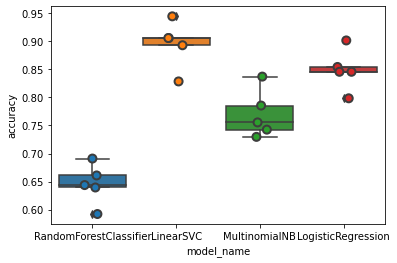

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [7]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.895279
LogisticRegression        0.848927
MultinomialNB             0.769957
RandomForestClassifier    0.645494
Name: accuracy, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
X_train, X_test, y_train, y_test = train_test_split(df['Test Case Description'], df['_pathTag'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train)

In [9]:
print(clf.predict(count_vect.transform(["""Verify user can use quick sort a-z for column 'Number'"""])))

['Grid/Sort']


In [10]:
import pickle

pickleVariable = {"model": clf, "count_vect": count_vect}
with open('testCasesClassification.pkl', 'wb') as file:
    pickle.dump(pickleVariable, file)
    
with open('testCasesClassification.pkl', 'rb') as file:
    pickleVariable = pickle.load(file)

model = pickleVariable["model"]
count_vect = pickleVariable["count_vect"]

In [11]:
print(model.predict(count_vect.transform(["""TM fuzzy matching, including 101% (order matching)"""])))

['TM']
